In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import logging
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import foolbox
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from lib.dataset_utils import *
from lib.cifar10_model import *
from lib.cwl2_attack import CWL2Attack

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [18]:
exp_id = 11

model_name = 'cifar10_resnet_exp%d.h5' % exp_id
net = PreActResNet(PreActBlock, [2, 2, 2, 2])
# net = BasicModel()

In [5]:
# Set all random seeds
seed = 2019
np.random.seed(seed)
torch.manual_seed(seed)

In [6]:
(x_train, y_train), (x_valid, y_valid), (x_test, y_test) = load_cifar10_all(
    '/data', val_size=0.1, shuffle=True, seed=seed)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set up model directory
save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

net = net.to(device)
# if device == 'cuda':
#     net = torch.nn.DataParallel(net)
#     cudnn.benchmark = True
net.load_state_dict(torch.load(model_path))
# net = net.module
# net = net.basic_net
_ = net.eval()

In [8]:
def classify(net, x):
    
    with torch.no_grad():
        y_pred = torch.zeros((x.size(0), 10))
        num = 0
        for i in range(x.size(0) // 100):
            begin = i * 100
            end = (i + 1) * 100
            y_pred[begin:end] = net(x[begin:end].to('cuda'))
        if (x.size(0) // 100) * 100 != x.size(0):
            begin = (i + 1) * 100
            end = (i + 2) * 100
            y_pred[begin:end] = net(x[begin:end].to('cuda'))
    return y_pred

In [9]:
y_pred = classify(net, x_test)
correct_idx = (y_pred.argmax(1).cpu() == y_test).numpy()
correct_idx = np.where(correct_idx)[0]
print('Test acc:', len(correct_idx) / y_test.size(0))

Test acc: 0.7323


In [120]:
acc = []
stds = 10 ** np.arange(-2, 0, 0.1)

for std in stds:
    with torch.no_grad():
        rnd = torch.randn_like(x_test) * std
        x_rnd = torch.clamp(x_test + rnd, 0, 1)
        y_pred = classify(net, x_rnd)
        acc.append((y_pred.argmax(1) == y_test).sum().numpy() / y_test.size(0))

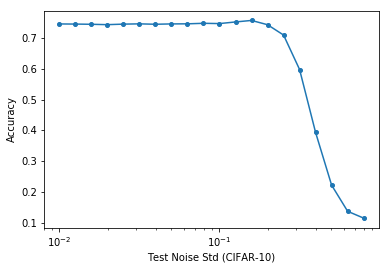

In [121]:
plt.plot(stds, acc, 'o-', markersize=4)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Test Noise Std (CIFAR-10)')
plt.ylabel('Accuracy')
plt.show()

---

In [10]:
# train_std = [0, 0.01, 0.02, 0.05, 0.1, 0.2]
train_std = [0, 0.05, 0.1, 0.2]

In [11]:
accs = []
stds = 10 ** np.arange(-2, 0, 0.1)

for i in range(11, 15):
    
    model_name = 'cifar10_resnet_exp%d.h5' % i
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    net.load_state_dict(torch.load(model_path))
    
    acc = []
    for std in stds:
        with torch.no_grad():
            rnd = torch.randn_like(x_test) * std
            x_rnd = torch.clamp(x_test + rnd, 0, 1)
            y_pred = classify(net, x_rnd)
            acc.append((y_pred.argmax(1) == y_test).sum().numpy() / y_test.size(0))
    accs.append(acc)

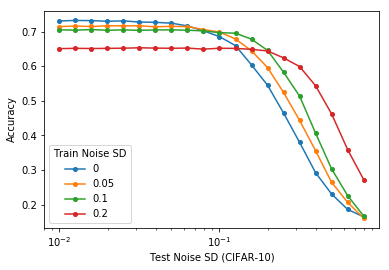

In [12]:
for i, acc in enumerate(accs):
    plt.plot(stds, acc, 'o-', label=train_std[i], markersize=4)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Test Noise SD (CIFAR-10)')
plt.ylabel('Accuracy')
plt.legend(title='Train Noise SD')
plt.show()

In [13]:
accs = []
stds = 10 ** np.arange(-2, 0, 0.1)

for i in range(11, 15):
    
    model_name = 'cifar10_resnet_exp%d.h5' % i
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    net.load_state_dict(torch.load(model_path))
    
    with torch.no_grad():
        y_pred = classify(net, x_test)
        correct_idx = np.where(y_pred.argmax(1) == y_test)[0]
    
        acc = []
        for std in stds:
            rnd = torch.randn_like(x_test[correct_idx]) * std
            x_rnd = torch.clamp(x_test[correct_idx] + rnd, 0, 1)
            y_pred = classify(net, x_rnd)
            acc.append((y_pred.argmax(1) == y_test[correct_idx]).sum().numpy() / len(correct_idx))
            
    accs.append(acc)

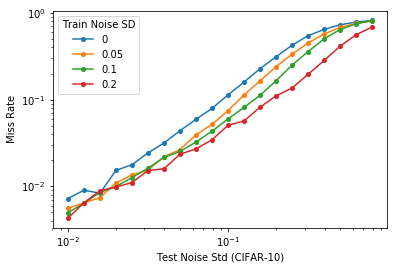

In [14]:
for i, acc in enumerate(accs):
    plt.plot(stds, 1 - np.array(acc), 'o-', label=train_std[i], markersize=4)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Test Noise Std (CIFAR-10)')
plt.ylabel('Miss Rate')
plt.legend(title='Train Noise SD')
plt.show()

In [15]:
# Test Hypothesis (3)

accs = []
stds = 10 ** np.arange(-2, 0, 0.1)

for i in range(11, 15):
    
    model_name = 'cifar10_resnet_exp%d.h5' % i
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    net.load_state_dict(torch.load(model_path))
    
    with torch.no_grad():
        y_pred = classify(net, x_test)
        inc_idx = np.where(y_pred.argmax(1) != y_test)[0]
    
        acc = []
        for std in stds:
            rnd = torch.randn_like(x_test[inc_idx]) * std
            x_rnd = torch.clamp(x_test[inc_idx] + rnd, 0, 1)
            y_pred = classify(net, x_rnd)
            acc.append((y_pred.argmax(1) == y_test[inc_idx]).sum().numpy() / len(inc_idx))
            
    accs.append(acc)

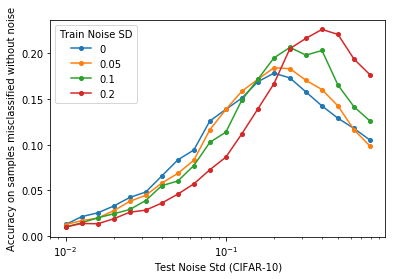

In [16]:
for i, acc in enumerate(accs):
    plt.plot(stds, np.array(acc), 'o-', label=train_std[i], markersize=4)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Test Noise Std (CIFAR-10)')
plt.ylabel('Accuracy on samples misclassified without noise')
plt.legend(title='Train Noise SD')
plt.show()

In [ ]:
y_pred = y_pred = classify(net, x_test[inc_idx] + rnd)

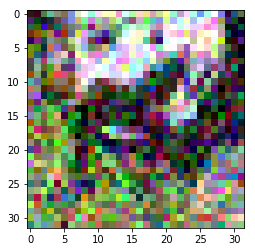

In [60]:
std = 0.2
rnd = torch.randn((3, 32, 32)) * std
plt.imshow(torch.clamp(x_test[20] + rnd, 0, 1).numpy().transpose(1, 2, 0))
plt.show()

---

Check the same effects on training set

In [18]:
accs = []
stds = 10 ** np.arange(-2, 0, 0.1)
num_test = 10000

for i in range(6):
    
    model_name = 'cifar10_resnet_exp%d.h5' % i
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    net.load_state_dict(torch.load(model_path))
    
    acc = []
    for std in stds:
        with torch.no_grad():
            rnd = torch.randn_like(x_train[:num_test]) * std
            y_pred = y_pred = classify(net, x_train[:num_test] + rnd)
            acc.append((y_pred.argmax(1) == y_train[:num_test]).sum().numpy() / num_test)
    accs.append(acc)

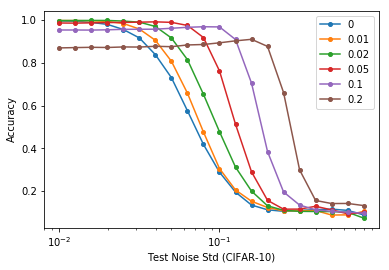

In [19]:
for i, acc in enumerate(accs):
    plt.plot(stds, acc, 'o-', label=train_std[i], markersize=4)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Test Noise Std (CIFAR-10)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Notice that the above plot looks exactly the same as the one with test set
# but the accuracy is just higher

In [20]:
accs = []
stds = 10 ** np.arange(-2, 0, 0.1)
num_test = 10000

for i in range(6):
    
    model_name = 'cifar10_resnet_exp%d.h5' % i
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    net.load_state_dict(torch.load(model_path))
    
    with torch.no_grad():
        y_pred = classify(net, x_train[:num_test])
        correct_idx = np.where(y_pred.argmax(1) == y_train[:num_test])[0]
    
        acc = []
        for std in stds:
            rnd = torch.randn_like(x_train[correct_idx]) * std
            y_pred = y_pred = classify(net, x_train[correct_idx] + rnd)
            acc.append((y_pred.argmax(1) == y_train[correct_idx]).sum().numpy() / len(correct_idx))
            
    accs.append(acc)

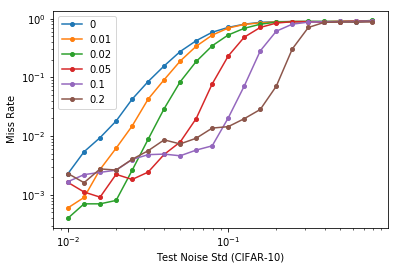

In [21]:
for i, acc in enumerate(accs):
    plt.plot(stds, 1 - np.array(acc), 'o-', label=train_std[i], markersize=4)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Test Noise Std (CIFAR-10)')
plt.ylabel('Miss Rate')
plt.legend()
plt.show()

---

Diagonal interpolation

In [93]:
num_test = 100
num_rnd = 100
num_steps = 10
radius = math.sqrt(3072) * 0.2
step_size = radius / num_steps
y_pred = torch.zeros((num_test, num_rnd, num_steps))

for i in range(num_test):
    
    x = x_test[i]
    
    noise = torch.randn((num_rnd, 3, 32, 32)).view(num_rnd, -1)
    noise = F.normalize(noise, 2, 1).view(num_rnd, 3, 32, 32)
    
    for j in range(num_rnd):
        
        inter = noise[j] * step_size * torch.arange(1, num_steps + 1).view(
            10, 1, 1, 1).type(torch.FloatTensor)
        y_pred[i, j] = classify(net, x + inter).argmax(1)

In [118]:
(y_pred.type(torch.LongTensor) == y_test[:num_test].view(num_test, 1, 1)).sum(1).type(torch.FloatTensor).mean(0)

tensor([74.3000, 74.6000, 75.1500, 75.8400, 77.0100, 78.3300, 79.3700, 80.1000,
        80.4800, 79.4700])

In [119]:
num_test = 1000
num_rnd = 100
num_steps = 10
radius = math.sqrt(3072) * 0.2 * 1.2
step_size = radius / num_steps
y_pred = torch.zeros((num_test, num_rnd, num_steps))

for i in range(num_test):
    
    x = x_test[i]
    
    noise = torch.randn((num_rnd, 3, 32, 32)).view(num_rnd, -1)
    noise = F.normalize(noise, 2, 1).view(num_rnd, 3, 32, 32)
    
    for j in range(num_rnd):
        
        inter = noise[j] * step_size * torch.arange(1, num_steps + 1).view(
            10, 1, 1, 1).type(torch.FloatTensor)
        y_pred[i, j] = classify(net, x + inter).argmax(1)

In [142]:
mean_acc = (y_pred.type(torch.LongTensor) == y_test[:num_test].view(num_test, 1, 1)).sum(
    1).sum(0).type(torch.FloatTensor) / (num_test * num_rnd)

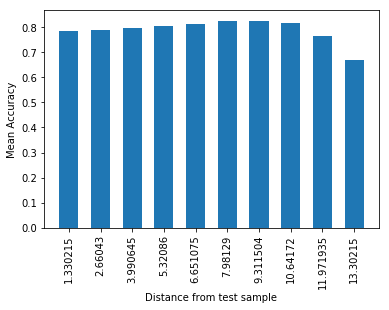

In [145]:
steps = step_size * torch.arange(1, num_steps + 1).type(torch.FloatTensor)
plt.bar(steps, mean_acc, tick_label=steps)
plt.xticks(rotation=90)
plt.xlabel('Distance from test sample')
plt.ylabel('Mean Accuracy')
plt.show()

In [147]:
# measure distance between classes

min_dist = torch.zeros(x_test.size(0))

for i in range(x_test.size(0)):
    
    dist = (x_test[i].unsqueeze(0) - x_test).view(x_test.size(0), -1).norm(2, 1)
    min_dist[i] = dist[y_test[i] != y_test].min()

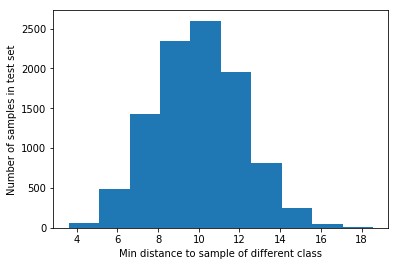

In [149]:
plt.hist(min_dist)
plt.xlabel('Min distance to sample of different class')
plt.ylabel('Number of samples in test set')
plt.show()

In [150]:
# average norm of Gaussian noise
math.sqrt(3072) * 0.2

11.085125168440815

In [154]:
np.percentile(min_dist, 1)

5.364959411621094

In [ ]:
# Check multiple noises per sample

In [26]:
accs = []
stds = 10 ** np.arange(-2, 0, 0.2)
num_test = 1000
num_rnd = 100
y_pred = torch.zeros((6, len(stds), num_test, num_rnd))

for i in range(6):
    
    model_name = 'cifar10_resnet_exp%d.h5' % i
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    net.load_state_dict(torch.load(model_path))
    
    for s, std in enumerate(stds):
        with torch.no_grad():
            
            for j in range(num_test):
                x = x_test[j] + torch.randn((num_rnd, 3, 32, 32)) * std
                y_pred[i, s, j] = classify(net, x).argmax(1)

In [38]:
acc = np.zeros((6, len(stds), num_rnd))
for i in range(6):
    acc[i] = (y_pred[i] == y_test[:num_test].unsqueeze(1).type(torch.float32)).type(torch.float32).mean(1)

[None]

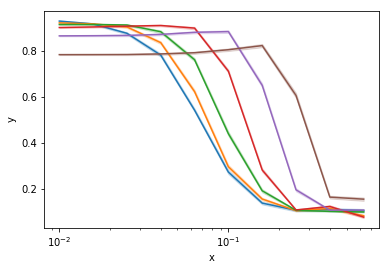

In [92]:
import seaborn as sns
import pandas as pd

for i in range(6):
    df = pd.DataFrame(dict(x=np.repeat(np.array(stds), num_rnd), y=acc[i].reshape(-1)))
    grid = sns.lineplot(x='x', y='y', ci='sd', data=df)

# grid.set(xscale="log", yscale="log")
grid.set(xscale="log")

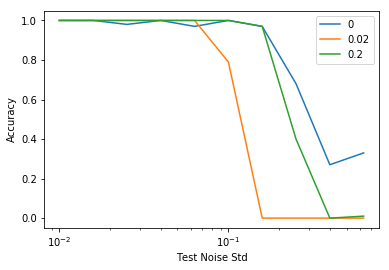

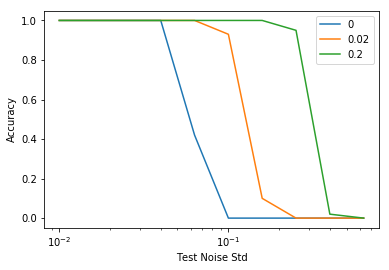

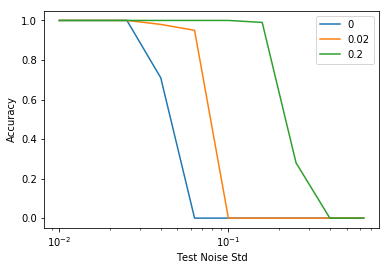

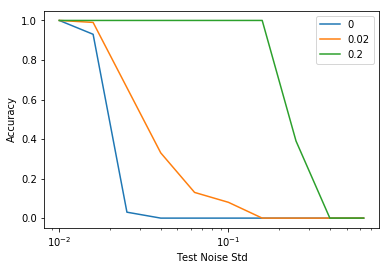

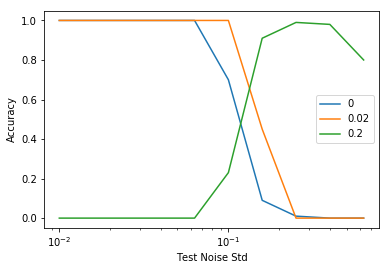

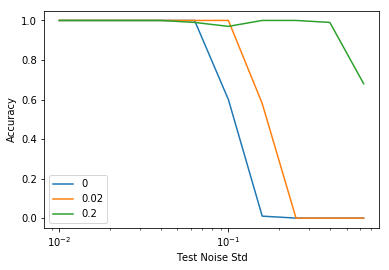

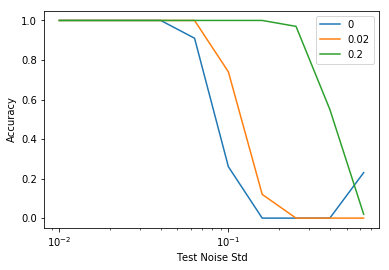

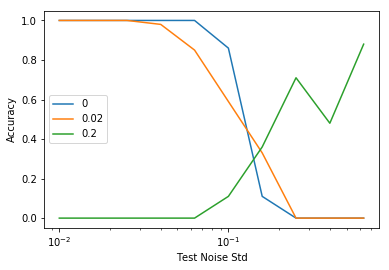

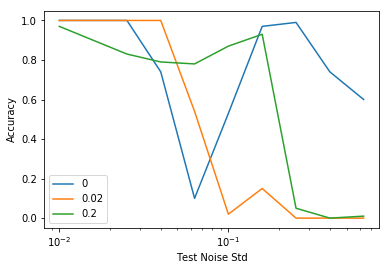

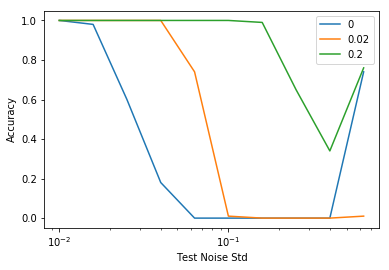

In [108]:
for idx in range(10):

    acc = np.zeros((6, len(stds)))
    for i in range(6):
        acc[i] = (y_pred[i, :, idx] == y_test[idx].type(torch.float32)).type(torch.float32).mean(1)
        
    for i in [0, 2, 5]:
        df = pd.DataFrame(dict(x=stds, y=acc[i]))
        grid = sns.lineplot(x='x', y='y', ci='sd', data=df, label=train_std[i])

    # grid.set(xscale="log", yscale="log")
    grid.set(xscale="log", 
             xlabel='Test Noise Std', 
             ylabel='Accuracy')
    plt.legend()
    plt.show()

In [109]:
accs = []
stds = 10 ** np.arange(-2, 0, 0.1)
num_test = 100
num_rnd = 1000
y_pred = torch.zeros((6, len(stds), num_test, num_rnd))

for i in range(6):
    
    model_name = 'cifar10_resnet_exp%d.h5' % i
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    net.load_state_dict(torch.load(model_path))
    
    for s, std in enumerate(stds):
        with torch.no_grad():
            
            for j in range(num_test):
                x = x_test[j] + torch.randn((num_rnd, 3, 32, 32)) * std
                y_pred[i, s, j] = classify(net, x).argmax(1)

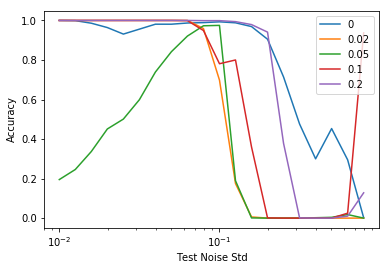

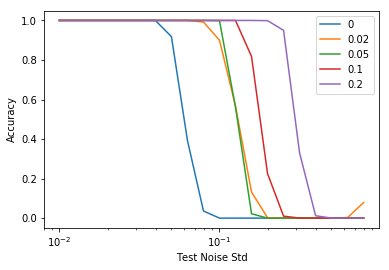

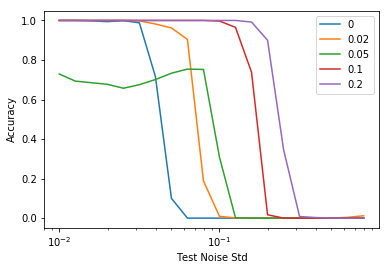

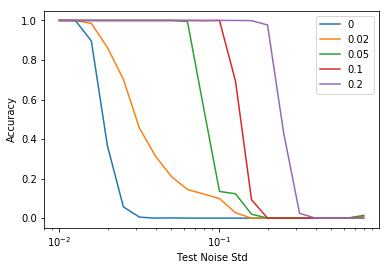

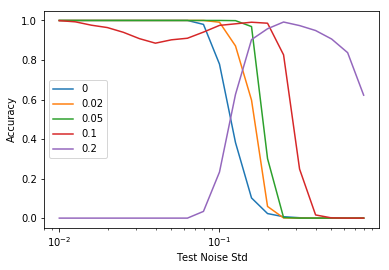

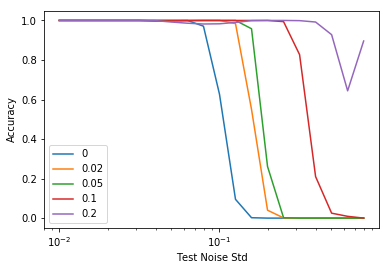

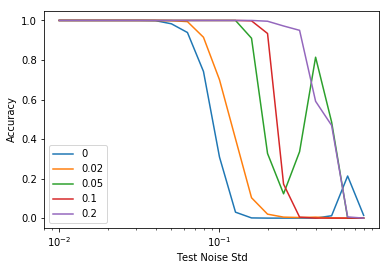

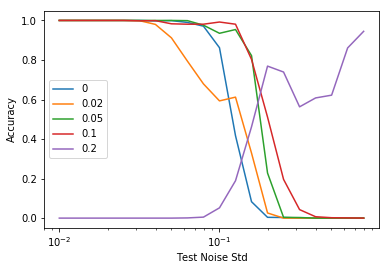

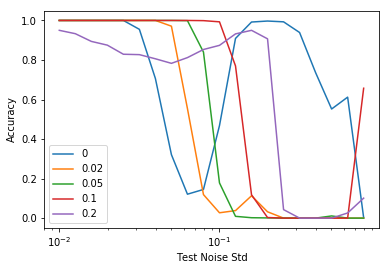

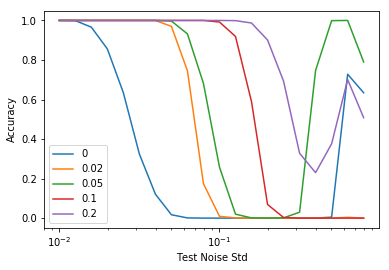

In [111]:
for idx in range(10):

    acc = np.zeros((6, len(stds)))
    for i in range(6):
        acc[i] = (y_pred[i, :, idx] == y_test[idx].type(torch.float32)).type(torch.float32).mean(1)
        
    for i in [0, 2, 3, 4, 5]:
        df = pd.DataFrame(dict(x=stds, y=acc[i]))
        grid = sns.lineplot(x='x', y='y', ci='sd', data=df, label=train_std[i])

    # grid.set(xscale="log", yscale="log")
    grid.set(xscale="log", 
             xlabel='Test Noise Std', 
             ylabel='Accuracy')
    plt.legend()
    plt.show()

In [125]:
num_test = 1000
num_rnd = 1000
sd = 0.2
y_pred = torch.zeros((num_test, num_rnd))
    
for i in range(num_rnd):

    noise = torch.randn_like(x_test[:num_test]) * sd
    x_rnd = torch.clamp(x_test[:num_test] + noise, 0, 1)
    y_pred[:, i] = classify(net, x_rnd).argmax(1)

In [126]:
acc_per_sample = (y_pred.type(torch.long) == y_test[:num_test].unsqueeze(1)).type(torch.float32).mean(1)

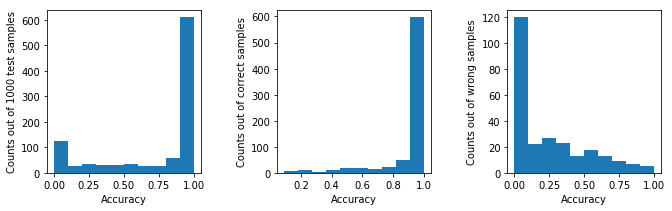

In [140]:
plt.figure(figsize=(11,3))
plt.subplot(131)
plt.hist(acc_per_sample)
plt.ylabel('Counts out of 1000 test samples')
plt.xlabel('Accuracy')
plt.subplot(132)
plt.hist(acc_per_sample[correct_idx[correct_idx < num_test]])
plt.ylabel('Counts out of correct samples')
plt.xlabel('Accuracy')
plt.subplot(133)
wrong_idx = np.setdiff1d(np.arange(num_test), correct_idx[correct_idx < num_test])
plt.hist(acc_per_sample[wrong_idx])
plt.ylabel('Counts out of wrong samples')
plt.xlabel('Accuracy')
plt.subplots_adjust(wspace=.5)
plt.show()

In [72]:
# x_high = x_test[:num_test][acc_per_sample > 0.9]
# y_high = y_test[:num_test][acc_per_sample > 0.9]

# x_high = x_test[:num_test][acc_per_sample < 0.9]
# y_high = y_test[:num_test][acc_per_sample < 0.9]

# x_high = x_test[correct_idx[correct_idx < num_test]]
# y_high = y_test[correct_idx[correct_idx < num_test]]

x_high = x_test[wrong_idx]
y_high = y_test[wrong_idx]
# y_high = classify(net, x_high).argmax(1).type(tensor.long)

In [69]:
attack = CWL2Attack()

def attack_batch(x, y, batch_size):
    x_adv = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = total_num // batch_size
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_adv[begin:end] = attack(
            net, x[begin:end], y[begin:end], targeted=False,
            binary_search_steps=10, max_iterations=500,
            confidence=0, learning_rate=1e-2,
            initial_const=1e-1, abort_early=True)
    return x_adv

x_adv = attack_batch(x_high.cuda(), y_high.cuda(), 100)

    step: 0; loss: 1.676; l2dist: 0.000
    step: 50; loss: 0.387; l2dist: 0.521
    step: 100; loss: 0.380; l2dist: 0.517
    step: 150; loss: 0.379; l2dist: 0.517
    step: 200; loss: 0.379; l2dist: 0.518
    step: 250; loss: 0.379; l2dist: 0.518
binary step: 0; number of successful adv: 79/100
    step: 0; loss: 4.140; l2dist: 0.000
    step: 50; loss: 0.432; l2dist: 0.538
    step: 100; loss: 0.396; l2dist: 0.523
    step: 150; loss: 0.394; l2dist: 0.521
    step: 200; loss: 0.394; l2dist: 0.522
binary step: 1; number of successful adv: 98/100
    step: 0; loss: 5.980; l2dist: 0.000
    step: 50; loss: 0.474; l2dist: 0.538
    step: 100; loss: 0.411; l2dist: 0.507
    step: 150; loss: 0.400; l2dist: 0.503
    step: 200; loss: 0.400; l2dist: 0.505
    step: 250; loss: 0.399; l2dist: 0.504
    step: 300; loss: 0.395; l2dist: 0.502
    step: 350; loss: 0.395; l2dist: 0.503
binary step: 2; number of successful adv: 100/100
    step: 0; loss: 3.698; l2dist: 0.000
    step: 50; loss: 0.4

    step: 50; loss: 0.450; l2dist: 0.492
    step: 100; loss: 0.384; l2dist: 0.465
    step: 150; loss: 0.373; l2dist: 0.461
    step: 200; loss: 0.368; l2dist: 0.459
    step: 250; loss: 0.366; l2dist: 0.459
    step: 300; loss: 0.365; l2dist: 0.458
    step: 350; loss: 0.365; l2dist: 0.458
    step: 400; loss: 0.365; l2dist: 0.458
binary step: 4; number of successful adv: 100/100
    step: 0; loss: 4.399; l2dist: 0.000
    step: 50; loss: 0.440; l2dist: 0.484
    step: 100; loss: 0.384; l2dist: 0.461
    step: 150; loss: 0.370; l2dist: 0.456
    step: 200; loss: 0.366; l2dist: 0.455
    step: 250; loss: 0.365; l2dist: 0.455
    step: 300; loss: 0.365; l2dist: 0.454
    step: 350; loss: 0.365; l2dist: 0.455
binary step: 5; number of successful adv: 100/100
    step: 0; loss: 4.175; l2dist: 0.000
    step: 50; loss: 0.436; l2dist: 0.483
    step: 100; loss: 0.383; l2dist: 0.459
    step: 150; loss: 0.370; l2dist: 0.454
    step: 200; loss: 0.365; l2dist: 0.452
    step: 250; loss: 0.36

    step: 250; loss: 0.371; l2dist: 0.459
    step: 300; loss: 0.372; l2dist: 0.460
binary step: 9; number of successful adv: 100/100
    step: 0; loss: 1.681; l2dist: 0.000
    step: 50; loss: 0.398; l2dist: 0.529
    step: 100; loss: 0.392; l2dist: 0.526
    step: 150; loss: 0.392; l2dist: 0.526
binary step: 0; number of successful adv: 80/100
    step: 0; loss: 4.367; l2dist: 0.000
    step: 50; loss: 0.436; l2dist: 0.546
    step: 100; loss: 0.410; l2dist: 0.529
    step: 150; loss: 0.407; l2dist: 0.528
    step: 200; loss: 0.406; l2dist: 0.528
    step: 250; loss: 0.406; l2dist: 0.528
binary step: 1; number of successful adv: 99/100
    step: 0; loss: 4.421; l2dist: 0.000
    step: 50; loss: 0.441; l2dist: 0.524
    step: 100; loss: 0.406; l2dist: 0.507
    step: 150; loss: 0.402; l2dist: 0.508
    step: 200; loss: 0.400; l2dist: 0.507
    step: 250; loss: 0.401; l2dist: 0.507
binary step: 2; number of successful adv: 99/100
    step: 0; loss: 21.641; l2dist: 0.000
    step: 50; l

In [71]:
# distance to boundary for correct samples
(x_adv.cpu() - x_high)[:600].view(-1, 3072).norm(2, 1).mean()

tensor(0.4675, grad_fn=<MeanBackward1>)

In [73]:
attack = CWL2Attack()

def attack_batch(x, y, batch_size):
    x_adv = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = total_num // batch_size
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_adv[begin:end] = attack(
            net, x[begin:end], y[begin:end], targeted=True,
            binary_search_steps=10, max_iterations=500,
            confidence=0, learning_rate=1e-1,
            initial_const=1e-1, abort_early=True)
    return x_adv

x_adv = attack_batch(x_high.cuda(), y_high.cuda(), 100)

    step: 0; loss: 0.776; l2dist: 0.000
    step: 50; loss: 0.193; l2dist: 0.373
    step: 100; loss: 0.191; l2dist: 0.364
    step: 150; loss: 0.199; l2dist: 0.367
binary step: 0; number of successful adv: 78/100
    step: 0; loss: 2.103; l2dist: 0.000
    step: 50; loss: 0.235; l2dist: 0.414
    step: 100; loss: 0.225; l2dist: 0.376
    step: 150; loss: 0.270; l2dist: 0.404
binary step: 1; number of successful adv: 98/100
    step: 0; loss: 2.486; l2dist: 0.000
    step: 50; loss: 0.232; l2dist: 0.389
    step: 100; loss: 0.225; l2dist: 0.363
    step: 150; loss: 0.246; l2dist: 0.370
binary step: 2; number of successful adv: 100/100
    step: 0; loss: 1.679; l2dist: 0.000
    step: 50; loss: 0.205; l2dist: 0.364
    step: 100; loss: 0.194; l2dist: 0.324
    step: 150; loss: 0.202; l2dist: 0.339
binary step: 3; number of successful adv: 100/100
    step: 0; loss: 1.279; l2dist: 0.000
    step: 50; loss: 0.188; l2dist: 0.344
    step: 100; loss: 0.172; l2dist: 0.309
    step: 150; loss

In [108]:
# distance to boundary of its correct class for wrong samples
dist = (x_adv.cpu() - x_high)[:300].view(-1, 3072).norm(2, 1)
dist.mean()

tensor(0.2916, grad_fn=<MeanBackward1>)

(array([25., 42., 49., 34., 37., 17., 21., 26., 13., 12.,  9.,  6.,  1.,
         2.,  3.,  1.,  0.,  0.,  1.,  1.]),
 array([0.00728018, 0.06720769, 0.1271352 , 0.18706271, 0.24699022,
        0.30691773, 0.36684522, 0.42677274, 0.48670024, 0.54662776,
        0.6065553 , 0.66648275, 0.72641027, 0.7863378 , 0.8462653 ,
        0.9061928 , 0.9661203 , 1.0260478 , 1.0859753 , 1.1459029 ,
        1.2058303 ], dtype=float32),
 <a list of 20 Patch objects>)

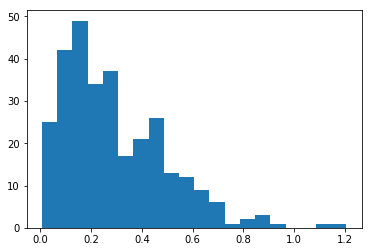

In [111]:
plt.hist(dist.detach().numpy(), bins=20)

Text(0, 0.5, 'acc')

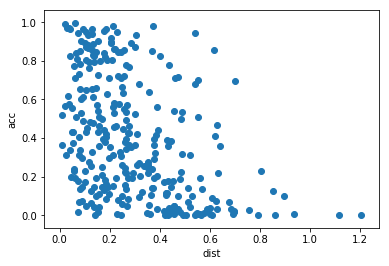

In [115]:
plt.scatter(dist[:300].detach().numpy(), acc_per_sample[wrong_idx][:300])
plt.xlabel('dist')
plt.ylabel('acc')

In [17]:
sum(p.numel() for p in net.parameters() if p.requires_grad)

10877898